# Example with a longitudinal dataset in BIDS

In [1]:
from IPython.display import Image

## Grab input data

In [2]:
models_dir = '../models' # Folder containing the models as .h5  
temp_dir = '/home/orco/data/WMH/SMARTAGE_BIDS/derivatives/wmhpypes_tmp' # Folder for the workflow's temporary files

In [3]:
import os
from nipype.pipeline.engine import Workflow, Node
from nipype import DataGrabber, DataSink, IdentityInterface

In [4]:
bids_root = '/home/orco/data/WMH/SMARTAGE_BIDS'

In [5]:
#Subject IDs
import os
sub_ids = [i for i in os.listdir(bids_root) if i.startswith('sub-')]
#sub_ids = sub_ids[10:11]
#print(sub_ids)

ses_ids = ['01', '02']
data_source = Node(interface=IdentityInterface(fields = ['weights', 'sub-id','ses-id']), name='data_source')
data_source.iterables = [('sub-id', sub_ids), ('ses-id', ses_ids)]

data_source.inputs.weights = [os.path.join(os.getcwd(), '../models', i) for i in os.listdir('../models')]

data_grabber = Node(interface=DataGrabber(infields=['sub-id', 'ses-id'],
                                          outfields=['flair']), name='data_grabber')
data_grabber.inputs.base_directory = bids_root
data_grabber.inputs.template = '%s/ses-%s/anat/%s_ses-%s_FLAIR.nii.gz'
data_grabber.inputs.template_args = {'flair' : [['sub-id', 'ses-id', 'sub-id', 'ses-id']]}
data_grabber.inputs.sort_filelist = False

['sub-SMART012']


## Preprocessing

We perform a minimal preprocessing comprising:
1. Brain Extraction (BET)
2. Denoising (ANTs)

In [6]:
import sys
sys.path.append('../')
#import os
#os.environ["KERAS_BACKEND"] = "tensorflow"
from nipype.interfaces import ants
from nipype.interfaces import fsl

from wmhpypes.interfaces import misc

In [7]:
bet = Node(interface=fsl.BET(reduce_bias=True,
                             frac=.2,
                             output_type='NIFTI'), name='bet')
denoising = Node(interface=ants.DenoiseImage(dimension=3), name='denoising')

## Segmentation

In [8]:
from wmhpypes.workflows import ibbmTum_wf

test_wf = ibbmTum_wf.get_test_wf(row_st=384,
                                     cols_st=384,
                                     thres_mask=10)

Rows and Cols can be taken from the NIfTI dimension

## Output

In [9]:
out_dir =  '/home/orco/data/WMH/SMARTAGE_BIDS/derivatives/WMHpypes' # Folder where we want to save the outputs 

In [10]:
sink = Node(interface=DataSink(), name = 'sink')
sink.inputs.base_directory = os.path.abspath(out_dir)
sink.inputs.regexp_substitutions = [(r'\.\.(.*)\.\.', '')]

## Connecting nodes

In [11]:
wmh_wf = Workflow(name='wmhpypes_wf', base_dir=temp_dir)
wmh_wf.connect(data_source, 'sub-id', data_grabber, 'sub-id')
wmh_wf.connect(data_source, 'ses-id', data_grabber, 'ses-id')
wmh_wf.connect(data_grabber, 'flair', bet, 'in_file')
wmh_wf.connect(bet, 'out_file', denoising, 'input_image')
wmh_wf.connect(denoising, 'output_image', test_wf, 'inputspec.flair')
wmh_wf.connect(data_source, 'weights', test_wf, 'inputspec.weights')
wmh_wf.connect(test_wf, 'outputspec.wmh_mask', sink, '@wmh_mask')

## Plot Workflow

220114-15:04:37,776 nipype.workflow INFO:
	 Generated workflow graph: ./imgs/example_wf.png (graph2use=colored, simple_form=True).


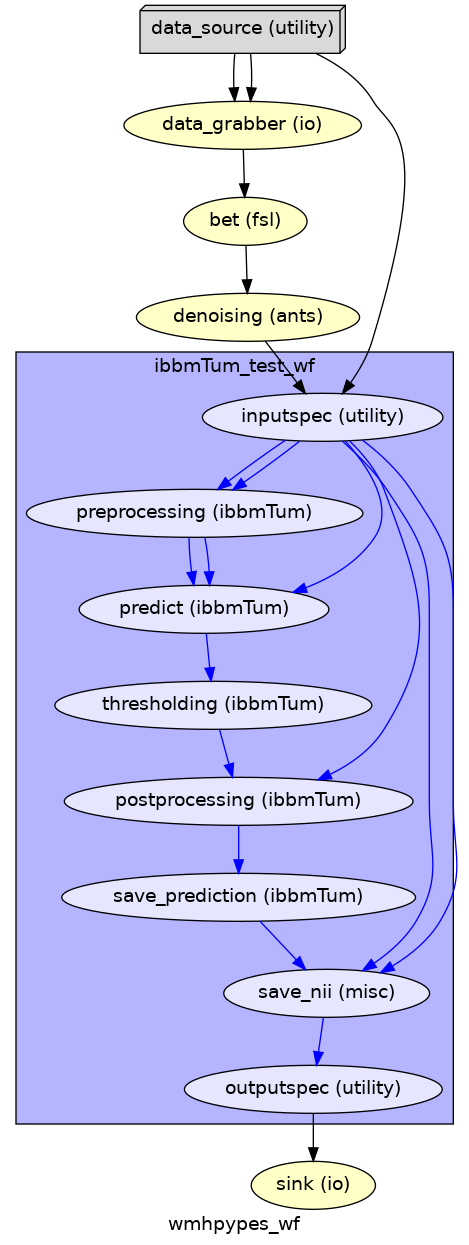

In [12]:
wmh_wf.write_graph(graph2use='colored', dotfilename='./imgs/example_wf.dot')
Image('./imgs/example_wf.png', width=300)

## Run it

In [13]:
plugin_args = {'n_procs': 32}
wmh_wf.run(plugin='MultiProc', plugin_args=plugin_args)

220114-15:04:40,324 nipype.workflow INFO:
	 Workflow wmhpypes_wf settings: ['check', 'execution', 'logging', 'monitoring']
220114-15:04:40,626 nipype.workflow INFO:
	 Running in parallel.
220114-15:04:40,628 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 2 jobs ready. Free memory (GB): 113.09/113.09, Free processors: 32/32.
220114-15:04:40,791 nipype.workflow INFO:
	 [Node] Setting-up "wmhpypes_wf.data_grabber" in "/run/user/1007/gvfs/smb-share:server=charite.de,share=centren/AG/AG-Floeel-Imaging/02-User/AndreaDellOrco/WhiteMatterLesions/SMARTAGE_BIDS/derivatives/wmhpypes_tmp/wmhpypes_wf/_ses-id_02_sub-id_sub-SMART012/data_grabber".
220114-15:04:40,892 nipype.workflow INFO:
	 [Node] Setting-up "wmhpypes_wf.data_grabber" in "/run/user/1007/gvfs/smb-share:server=charite.de,share=centren/AG/AG-Floeel-Imaging/02-User/AndreaDellOrco/WhiteMatterLesions/SMARTAGE_BIDS/derivatives/wmhpypes_tmp/wmhpypes_wf/_ses-id_01_sub-id_sub-SMART012/data_grabber".
220114-15:04:41,184 nipype.workflo

sizeof_hdr should be 540; set sizeof_hdr to 540
sizeof_hdr should be 540; set sizeof_hdr to 540


220114-15:06:09,774 nipype.workflow INFO:
	 [Node] Finished "save_nii", elapsed time 0.500002s.
220114-15:06:09,800 nipype.workflow INFO:
	 [Node] Finished "save_nii", elapsed time 0.521877s.
220114-15:06:10,702 nipype.workflow INFO:
	 [Job 8] Completed (wmhpypes_wf.ibbmTum_test_wf.save_nii).
220114-15:06:10,703 nipype.workflow INFO:
	 [Job 18] Completed (wmhpypes_wf.ibbmTum_test_wf.save_nii).
220114-15:06:10,704 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 2 jobs ready. Free memory (GB): 113.09/113.09, Free processors: 32/32.
220114-15:06:10,786 nipype.workflow INFO:
	 [Node] Setting-up "wmhpypes_wf.sink" in "/run/user/1007/gvfs/smb-share:server=charite.de,share=centren/AG/AG-Floeel-Imaging/02-User/AndreaDellOrco/WhiteMatterLesions/SMARTAGE_BIDS/derivatives/wmhpypes_tmp/wmhpypes_wf/_ses-id_02_sub-id_sub-SMART012/sink".
220114-15:06:10,794 nipype.workflow INFO:
	 [Node] Setting-up "wmhpypes_wf.sink" in "/run/user/1007/gvfs/smb-share:server=charite.de,share=centren/AG/AG-Flo

## Results

To plot the NIfTIs we will use NIlearn plotting capabilities

In [ ]:
import nilearn.plotting as plotting

#### Input file

In [ ]:
flair = './test_dataset/FLAIR.nii.gz'
out = './out/_flairs_test_flair.nii.gz/prediction.nii.gz'

In [ ]:
plotting.plot_anat(flair)

#### Result

In [ ]:
plotting.plot_roi(out, flair) #, display_mode='mosaic' )

In [ ]:
plotting.plot_anat(out)